In [3]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/andreanavarrete/.config/gcloud/DSI Capstone F19 Group 1-35883630d316.json'

In [4]:
import matplotlib.pyplot as plt
from google.cloud import bigquery

%load_ext google.cloud.bigquery

In [5]:
bigquery_client = bigquery.Client(project='dsi-capstone-f19-group-1')

In [6]:
%%bigquery df_date
select EXTRACT(DATE from created_at) as date, count(*) as count_tweets, 
        count(distinct id) as unique_id,
        count(distinct user_id) as unique_user_id,
        sum(cast(user_verified as INT64)) as num_verified
from tweets.all_tweets group by 1;

In [7]:
df_date.head()

,date,count_tweets,unique_id,unique_user_id,num_verified
0,2014-08-17,537967,537727,154379,18088
1,2014-08-14,1556308,1554959,428075,52019
2,2014-08-22,234485,234188,100959,8592
3,2014-08-18,1065025,1063960,311135,40280
4,2014-08-27,82287,82197,44990,3317


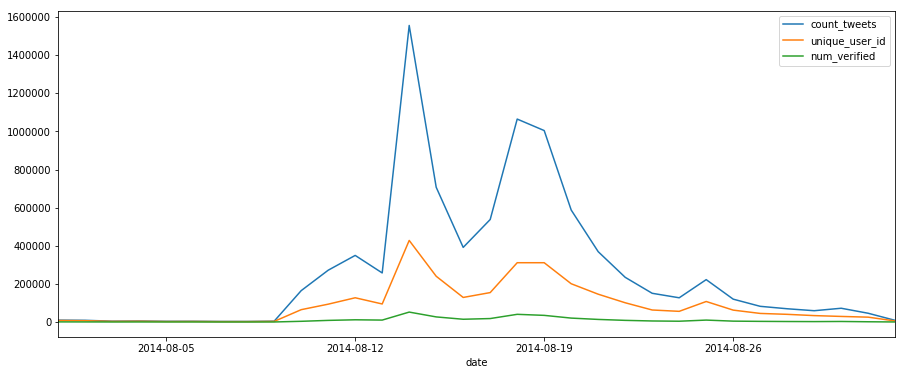

In [8]:
ax = df_date.plot(x='date',
             y='count_tweets',
             kind='line',
             figsize=(15,6))
df_date.plot(x='date',
            y='unique_user_id',
            kind='line',
            ax=ax)
df_date.plot(x='date',
            y='num_verified',
            kind='line',
            ax=ax)